<a href="https://colab.research.google.com/github/FredLongo/Cancer_Detection_Project/blob/main/classifier_CNN_PC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Classifier CNN Performs the following**
   The purpose of the Classifier CNN is to crate and train a model to identify ROI areas (nodules) as being malignant or not.  By doing this we get a classification model that can be used by other programs.

*   Preps Environment
*   Preprocess Data
*   Preps the data for training
*   Builds the Model
*   Train the model
*   Save the best model off to be used later

---

---
By Fred Longo

---

---
Prep Environment

---




In [ ]:
!pip install SimpleITK

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
import SimpleITK as stk
from glob import glob
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/PCAI_Project

/content/drive/MyDrive/PCAI_Project


In [ ]:
pd.set_option('display.max_colwidth', 200)

---
Preprocess Data

---

In [ ]:
root = "subset0/"
target_root = "FPRProcessedData/"

In [ ]:
# Clean up from last run
#!rm -r FPRProcessedData/nodule/*
#!rm -r FPRProcessedData/non-nodule/*
#!rm -r FPRProcessedData/non-nodule-initial/*

#!rm -r FPRDataset/test/nodule/*
#!rm -r FPRDataset/test/non-nodule/*
#!rm -r FPRDataset/train/nodule/*
#!rm -r FPRDataset/train/non-nodule/*



In [ ]:
#os.chdir("../../")
#if os.path.exists("FPRDataset"): shutil.rmtree("FPRDataset")
#os.mkdir("FPRDataset")
#if os.path.exists("FPRDataset/train"): shutil.rmtree("FPRDataset/train")
#os.mkdir("FPRDataset/train")
#if os.path.exists("FPRDataset/train/nodule"): shutil.rmtree("FPRDataset/train/nodule")
#os.mkdir("FPRDataset/train/nodule")
#if os.path.exists("FPRDataset/train/non-nodule"): shutil.rmtree("FPRDataset/train/non-nodule")
#os.mkdir("FPRDataset/train/non-nodule")
#if os.path.exists("FPRDataset/test"): shutil.rmtree("FPRDataset/test")
#os.mkdir("FPRDataset/test")
#if os.path.exists("FPRDataset/test/nodule"): shutil.rmtree("FPRDataset/test/nodule")
#os.mkdir("FPRDataset/test/nodule")
#if os.path.exists("FPRDataset/test/non-nodule"): shutil.rmtree("FPRDataset/test/non-nodule")
#os.mkdir("FPRDataset/test/non-nodule")


In [ ]:
file_list = glob(root+"/*.mhd")
print("Files Count:",len(file_list))

Files Count: 89


In [ ]:
candidates_df = pd.read_csv("candidates.csv")

In [ ]:
candidates_df.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860,-32.25,-85.36,-362.51,0


In [ ]:
print("Total Candidates:",len(candidates_df))
print("Positives:",candidates_df['class'].sum())

Total Candidates: 551065
Positives: 1351


In [ ]:
candidates_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   seriesuid  551065 non-null  object 
 1   coordX     551065 non-null  float64
 2   coordY     551065 non-null  float64
 3   coordZ     551065 non-null  float64
 4   class      551065 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [ ]:
def get_filename(file_list, file):
    for f in file_list:
        if file in f:
            return f

In [ ]:
def load_mhd(file):
    mhdimage = stk.ReadImage(file)
    ct_scan = stk.GetArrayFromImage(mhdimage)
    origin = np.array(list(mhdimage.GetOrigin()))
    space = np.array(list(mhdimage.GetSpacing()))
    return ct_scan, origin, space

In [ ]:
def mark_done(path):
    with open(path[:-3]+'done', 'a'):
        pass


In [ ]:
def is_done(path):
    return os.path.exists(path[:-3]+'done')

In [ ]:
candidates_df["filename"] = candidates_df["seriesuid"].map(lambda file: get_filename(file_list, file))
candidates_df = candidates_df.dropna()
print(len(candidates_df))

56938


In [ ]:
candidates_df.head()

,seriesuid,coordX,coordY,coordZ,class,filename
9310,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260,129.568151,45.377097,-277.835758,0,subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
9311,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260,-97.260000,56.360000,-201.930000,0,subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
9312,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260,99.230491,-4.882165,-128.691305,0,subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
9313,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260,-15.287525,-59.105100,-251.303750,0,subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
9314,1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260,109.344666,1.891737,-237.284699,0,subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd


In [ ]:
subset = 0

In [ ]:
#rm 'subset0/'*.'done'         # Run this only if you want to delete the marking of the files that have allready been processed because you want to reprocess them.

In [ ]:
##Loads the *.mhd files and Classifies them based on the Candidates file info
##Slices out the candidate section into a 512X512 image
## If its a candidate applies image transformations and saves to files to nodual directory
## if not a candidate writes it to the non-nodule-initial directory.

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # CLAHE(Contrast Limited Adaptive Histogram Equalization) filter for enhancing the contrast of an image
for i,file in tqdm(enumerate(np.unique(candidates_df['filename'].values))):
    candidates = candidates_df[candidates_df["filename"]==file]
    done_flag = is_done(file)

    print('Is Done:', done_flag, 'file:',file)
    if os.path.exists(file) and not done_flag:
        try:
          ct, origin, space = load_mhd(file)
          num_z, height, width = ct.shape
          ct_norm = cv2.normalize(ct, None, 0, 255, cv2.NORM_MINMAX)
          for idx, row in candidates.iterrows():
              node_x = int(row["coordX"])     # x-coordinate of the candidate
              node_y = int(row["coordY"])     # y-coordinate of the candidate
              node_z = int(row["coordZ"])     # z-coordinate of the candidate
              c = int(row["class"])           # class of the candidate (1: nodule, 0: non-nodule)

              center = np.array([node_x, node_y, node_z])   # nodule center
              v_center = np.rint((center-origin)/space)   # nodule center in voxel space (still x,y,z ordering)

              img_norm = ct_norm[int(v_center[2]),:,:]    # a slice of the CT scan containing the candidate
              img_norm = cv2.resize(img_norm, (512,512))  # resize the image to 512x512
              img_norm_improved = clahe.apply(img_norm.astype(np.uint8))  # apply CLAHE filter to the image

              x=abs(int(v_center[0]))
              y=abs(int(v_center[1]))
              box = img_norm_improved[max(0,y-25):min(y+25,512),max(0,x-25):min(x+25,512)]    # extract a box of size 25x25 around the candidate
              if box.shape != (50,50):
                  box = cv2.resize(box, (50,50))

              if c:  # if the candidate is a nodule
                  # applying different image transformations to increase the number of nodule candidates
                  cv2.imwrite(os.path.join(target_root+"nodule/", f"candidate_{subset}_{c}_{idx}.jpg"),box)
                  cv2.imwrite(os.path.join(target_root+"nodule/", f"candidate_{subset}_{c}_{idx}_1.jpg"),cv2.rotate(box,cv2.ROTATE_90_CLOCKWISE))
                  cv2.imwrite(os.path.join(target_root+"nodule/", f"candidate_{subset}_{c}_{idx}_2.jpg"),cv2.rotate(box, cv2.ROTATE_90_COUNTERCLOCKWISE))
                  cv2.imwrite(os.path.join(target_root+"nodule/", f"candidate_{subset}_{c}_{idx}_3.jpg"),cv2.rotate(box, cv2.ROTATE_180))
                  cv2.imwrite(os.path.join(target_root+"nodule/", f"candidate_{subset}_{c}_{idx}_4.jpg"),cv2.flip(box, 1))
              else:  # if the candidate is not a nodule
                  cv2.imwrite(os.path.join(target_root+"non-nodule-initial/", f"candidate_{subset}_{c}_{idx}.jpg"),box)
          mark_done(file)
        except RuntimeError as error:
          print("An error occurred while trying to read the image in file:",file )
          print(str(error))


0it [00:00, ?it/s]

Is Done: True file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd
Is Done: True file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.mhd
Is Done: True file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059.mhd
Is Done: True file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987.mhd
Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720.mhd


5it [00:12,  2.49s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565.mhd


6it [00:25,  4.88s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514.mhd


7it [00:33,  5.54s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354.mhd


8it [00:44,  7.11s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912.mhd


9it [00:54,  7.64s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.129055977637338639741695800950.mhd


10it [01:02,  7.84s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.mhd


11it [01:13,  8.63s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.134996872583497382954024478441.mhd


12it [01:20,  8.37s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097.mhd


13it [01:26,  7.67s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686.mhd


14it [01:36,  8.32s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139258777898746693365877042411.mhd


15it [01:44,  8.30s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.139713436241461669335487719526.mhd


16it [01:58,  9.86s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.141069661700670042960678408762.mhd


17it [02:10, 10.58s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.144438612068946916340281098509.mhd


18it [02:19, 10.13s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.146429221666426688999739595820.mhd


19it [02:27,  9.36s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227.mhd


20it [02:32,  8.21s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748.mhd


21it [02:37,  6.99s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188209889686363159853715266493.mhd


22it [02:41,  6.20s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.188376349804761988217597754952.mhd


23it [02:49,  6.91s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194440094986948071643661798326.mhd


24it [02:56,  6.71s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.194465340552956447447896167830.mhd


25it [03:03,  6.77s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196.mhd


26it [03:12,  7.50s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.210837812047373739447725050963.mhd


27it [03:19,  7.40s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074.mhd


28it [03:28,  7.82s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.mhd


29it [03:33,  7.02s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219087313261026510628926082729.mhd


30it [03:45,  8.48s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.219909753224298157409438012179.mhd


31it [03:56,  9.31s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223.mhd


32it [04:01,  8.04s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.mhd


33it [04:10,  8.27s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.238522526736091851696274044574.mhd


34it [04:15,  7.35s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.241570579760883349458693655367.mhd


35it [04:30,  9.73s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730.mhd


36it [04:39,  9.48s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.mhd


37it [04:45,  8.45s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.mhd


38it [04:59,  9.94s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860.mhd


39it [05:07,  9.56s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865.mhd


40it [05:14,  8.60s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.277445975068759205899107114231.mhd


41it [05:20,  7.97s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.mhd


42it [05:27,  7.58s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.280972147860943609388015648430.mhd


43it [05:36,  8.00s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.281489753704424911132261151767.mhd


44it [05:46,  8.75s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.mhd


45it [05:56,  9.12s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.294188507421106424248264912111.mhd


46it [06:05,  9.01s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd


47it [06:13,  8.71s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663.mhd


48it [06:29, 10.73s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.302134342469412607966016057827.mhd


49it [06:38, 10.36s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.303421828981831854739626597495.mhd


50it [06:45,  9.39s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.305858704835252413616501469037.mhd


51it [06:57, 10.20s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310548927038333190233889983845.mhd


52it [07:07, 10.03s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.310626494937915759224334597176.mhd


53it [07:14,  9.02s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.311981398931043315779172047718.mhd


54it [07:27, 10.18s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733.mhd


55it [07:38, 10.59s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313605260055394498989743099991.mhd


56it [07:48, 10.28s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490.mhd


57it [08:00, 11.05s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.317087518531899043292346860596.mhd


58it [08:12, 11.33s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323302986710576400812869264321.mhd


59it [08:21, 10.35s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.323859712968543712594665815359.mhd


60it [08:27,  9.20s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.332453873575389860371315979768.mhd


61it [08:37,  9.38s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.mhd


62it [08:48, 10.06s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.334517907433161353885866806005.mhd


63it [09:02, 11.23s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.mhd


64it [09:12, 10.77s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.397062004302272014259317520874.mhd


65it [09:21, 10.13s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.mhd


66it [09:26,  8.69s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.417815314896088956784723476543.mhd


67it [09:38,  9.58s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.mhd


68it [09:48,  9.87s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.450501966058662668272378865145.mhd


69it [10:00, 10.33s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.511347030803753100045216493273.mhd


71it [10:20,  9.28s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd
An error occurred while trying to read the image in file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd
Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/Meta/src/itkMetaImageIO.cxx:483:
ITK ERROR: MetaImageIO(0x5caaa2bd3cd0): File cannot be read: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.525937963993475482158828421281.mhd for reading.
Reason: No such file or directory
Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547.mhd


72it [10:33, 10.44s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.mhd


73it [10:39,  9.04s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.mhd


74it [10:50,  9.73s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd


75it [10:50,  6.89s/it]

An error occurred while trying to read the image in file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd
Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK-build/ITK/Modules/IO/Meta/src/itkMetaImageIO.cxx:483:
ITK ERROR: MetaImageIO(0x5caaa2bd3cd0): File cannot be read: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.566816709786169715745131047975.mhd for reading.
Reason: No such file or directory
Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.621916089407825046337959219998.mhd


76it [11:00,  7.77s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.640729228179368154416184318668.mhd


77it [11:09,  8.09s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056.mhd


78it [11:18,  8.26s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.716498695101447665580610403574.mhd


79it [11:27,  8.72s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.724251104254976962355686318345.mhd


80it [11:39,  9.47s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.752756872840730509471096155114.mhd


81it [11:50, 10.02s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.805925269324902055566754756843.mhd


82it [11:58,  9.33s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.826812708000318290301835871780.mhd


83it [12:07,  9.34s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.832260670372728970918746541371.mhd


84it [12:13,  8.21s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.868211851413924881662621747734.mhd


85it [12:22,  8.70s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.mhd


86it [12:32,  8.90s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.905371958588660410240398317235.mhd


87it [12:44,  9.97s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.975254950136384517744116790879.mhd


88it [12:56, 10.55s/it]

Is Done: False file: subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.979083010707182900091062408058.mhd


89it [13:07,  8.85s/it]


In [ ]:
import random
import os
import shutil
from tqdm import tqdm

In [ ]:
root = "FPRProcessedData/non-nodule-initial/"
target = "FPRProcessedData/non-nodule/"

In [ ]:
# sometimes this fails with error, Not sure why but just run it again if it does.
filelist = os.listdir(root)


In [ ]:
filelist_count = len(filelist)

In [ ]:
filelist_count

In [ ]:
# Number of non nodule images is too high compared to the number of nodule images.
# Therefore, we will use only filelist_limit non nodule images.(original 10000)
filelist_limit = 10000
finalfiles = filelist[:filelist_limit]
for file in tqdm(finalfiles, total=filelist_limit):
    s = root+file
    d = target+file
    shutil.copy(s,d)


In [ ]:

nodule_files = os.listdir("FPRProcessedData/nodule/")
non_nodule_files = os.listdir("FPRProcessedData/non-nodule/")


20000

In [ ]:
random.shuffle(nodule_files)
random.shuffle(non_nodule_files)


In [ ]:
n = len(nodule_files)
split = int(0.75*n)
for i in nodule_files[:split]:
    shutil.copy(f"FPRProcessedData/nodule/{i}", f"FPRDataset/train/nodule/{i}")
for i in nodule_files[split:]:
    shutil.copy(f"FPRProcessedData/nodule/{i}", f"FPRDataset/test/nodule/{i}")


In [ ]:
n = len(non_nodule_files)
split = int(0.75*n)
for i in non_nodule_files[:split]:
    shutil.copy(f"FPRProcessedData/non-nodule/{i}", f"FPRDataset/train/non-nodule/{i}")
for i in non_nodule_files[split:]:
    shutil.copy(f"FPRProcessedData/non-nodule/{i}", f"FPRDataset/test/non-nodule/{i}")


---
Prep Training Data

---
This area preps the data varables to be used by the models for training

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Input, Flatten
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import clear_output


In [ ]:
BATCH_SIZE = 10
generator = ImageDataGenerator(rescale=1./255)
trainData = generator.flow_from_directory(
    "FPRDataset/train",
    target_size=(50,50),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)
testData = generator.flow_from_directory(
    "FPRDataset/test",
    target_size=(50,50),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary'
)

Found 560 images belonging to 2 classes.
Found 9091 images belonging to 2 classes.


---
Build the Models

---

In [ ]:
#weight_path="CNN-checkpoint-{epoch:03d}-{val_loss:.3f}.hdf5"
weight_path="CNN-checkpoint.hdf5"
modelcheckpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

In [ ]:
import numpy as np
from keras import models
from keras.models import Sequential
from keras.layers import Dense , MaxPooling2D


def get_model():
    model = Sequential()
    # Add Convolutional layers
    model.add(Conv2D(50, (3, 3), activation='relu', input_shape=(50,50,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))

    # Flatten the output of the Convolutional layers
    model.add(Flatten())

    # Add Dense layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model



In [ ]:

model = get_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 50)        500       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        28864     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 5184)              0

In [ ]:
history = model.fit(
      trainData,
      validation_data=testData,
      epochs=10,
      verbose=1,  callbacks=[modelcheckpoint])

Epoch 1/10
56/56 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9857
Epoch 1: val_loss improved from inf to 250.44296, saving model to CNN-checkpoint.hdf5
56/56 [==============================] - 2596s 47s/step - loss: 0.0211 - accuracy: 0.9857 - val_loss: 250.4430 - val_accuracy: 0.0390
Epoch 2/10
56/56 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 2: val_loss did not improve from 250.44296
56/56 [==============================] - 49s 885ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 254.0122 - val_accuracy: 0.0390
Epoch 3/10
56/56 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 250.44296
56/56 [==============================] - 47s 848ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 254.0246 - val_accuracy: 0.0390
Epoch 4/10
56/56 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4: val_loss 

In [ ]:
history = model.fit(
      trainData,
      epochs=10,
      verbose=1)


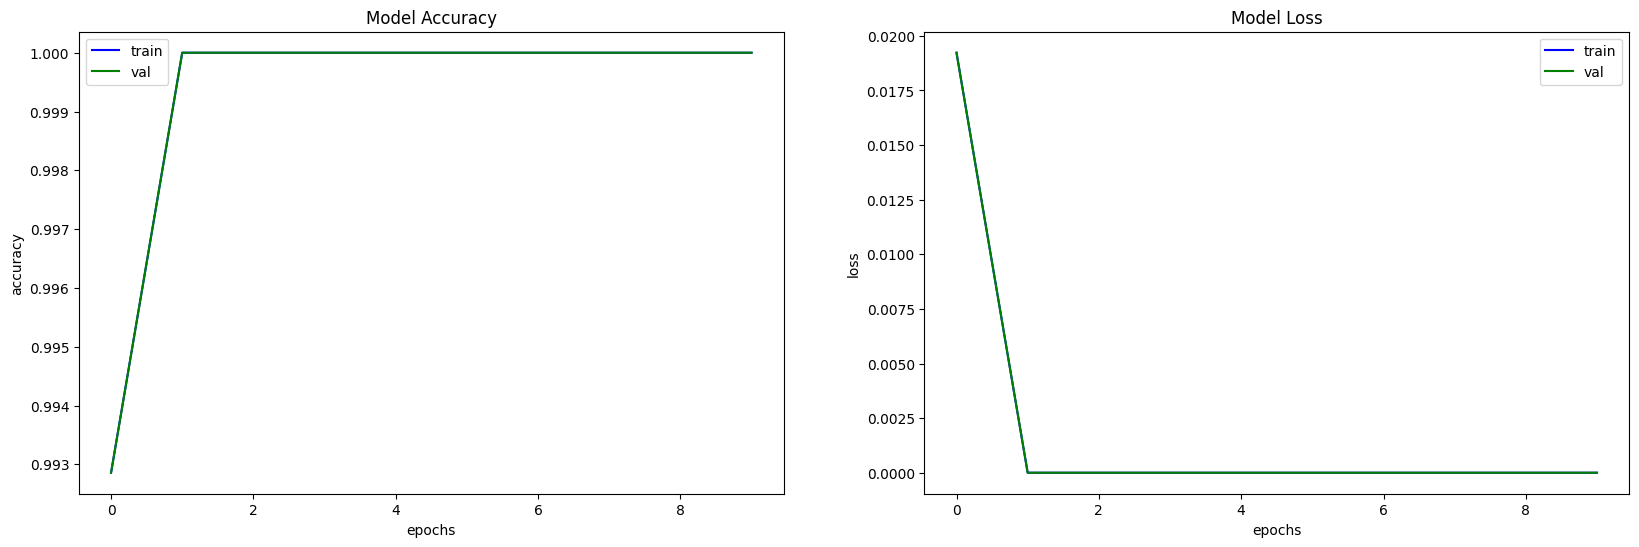

In [ ]:
plt.figure(figsize=(20,6))
for i, met in enumerate(['accuracy', 'loss']):
  plt.subplot(1,2,i+1)
  #plt.plot(history.history[met], color="b")
  plt.plot(history.history[met], color="g")
  plt.title('Model '+met.capitalize())
  plt.xlabel('epochs')
  plt.ylabel(met)
  plt.legend(['train', 'val'])

In [ ]:
history.history

{'loss': [0.01922946609556675,
  6.326799179988678e-32,
  1.4981465087741257e-31,
  1.4929616382915188e-31,
  6.586853795221093e-32,
  6.34207649231914e-32,
  6.540724458158949e-32,
  4.92343075887107e-29,
  1.1340198244526063e-32,
  1.3849775063704622e-30],
 'accuracy': [0.9928571581840515, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'val_loss': [158.40029907226562,
  160.44964599609375,
  160.45697021484375,
  160.4570770263672,
  160.4568634033203,
  160.4568328857422,
  160.45687866210938,
  160.4569854736328,
  160.45687866210938,
  160.4569549560547],
 'val_accuracy': [0.03904961049556732,
  0.03904961049556732,
  0.03904961049556732,
  0.03904961049556732,
  0.03904961049556732,
  0.03904961049556732,
  0.03904961049556732,
  0.03904961049556732,
  0.03904961049556732,
  0.03904961049556732]}

---
Save the Model

----

In [ ]:
from datetime import datetime

# Get the current date and time
now = datetime.now()

# Format the date and time
formatted_now = now.strftime("%Y%m%d_%H%M%S")

# Define your filename
filename = f"CNN_model_{formatted_now}.h5"

model.save(filename)

---
Example Of how to pull from one of the checkpoints.

---

In [ ]:
# Pulling  up a checkpoint model weights and recreating it at that point and saving it.

model2 = get_model()
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model2.load_weights("checkpoint-003-0.189.hdf5")
model2.save("checkpoint_model.h5")
#model2.save("FPR_classifier_model.h5")

